In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import shap


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import RocCurveDisplay,roc_curve,auc,recall_score
from sklearn.metrics import precision_score
import xgboost as xgb
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import glob
from sklearn.model_selection import GridSearchCV

In [19]:
#folder_path = '../Data/preprocessed/raw/pi-_10GeV_4ly_1e-4/'
#file_list = glob.glob(folder_path + 'TrkData_viewx_cl_TB_2023_T10_Sept_pi-Mono_10000_onAxis_10000-evt-1*_pitch0.25node_df.parquet')

In [20]:
#%%time
#file_list=file_list[:40]

#node_df_pi = pd.DataFrame()

#for file_path in file_list:
#    df = pd.read_parquet(file_path)
#    node_df_pi = pd.concat([node_df_pi, df], ignore_index=True)

In [3]:
def string_to_float(string):
    return float(string.strip('[]'))


In [4]:
#file_path = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_e-20000MeV.csv"
#file_path_proton = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_proton20000MeV.csv"
file_path = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_e-20000MeV.csv"
file_path_proton = "/lustrehome/mbossa/Nuses/Analysis/CaloPara_proton20000MeV.csv"

In [5]:
df_e = pd.read_csv(file_path)
df_p = pd.read_csv(file_path_proton)

In [6]:
df_e['R1'] = df_e['R1'].apply(string_to_float)
df_e['R2'] = df_e['R2'].apply(string_to_float)
df_e['R4'] = df_e['R4'].apply(string_to_float)
df_e['R5'] = df_e['R5'].apply(string_to_float)
df_e['R6'] = df_e['R6'].apply(string_to_float)

df_p['R1'] = df_p['R1'].apply(string_to_float)
df_p['R2'] = df_p['R2'].apply(string_to_float)
df_p['R4'] = df_p['R4'].apply(string_to_float)
df_p['R5'] = df_p['R5'].apply(string_to_float)
df_p['R6'] = df_p['R6'].apply(string_to_float)


In [7]:
df_e['R3'] = df_e['R3'].apply(lambda x: eval(x) if isinstance(x, str) else np.nan)
df_p['R3'] = df_p['R3'].apply(lambda x: eval(x) if isinstance(x, str) else np.nan)

In [8]:
for i in range(25):
    #df_e[f'R3_{i+1}'] = df_e['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else np.nan)
        df_e[f'R3_{i+1}'] = df_e['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else 0)
df2 = df_e.drop(columns=['R3'])

In [9]:
for i in range(25):
    #df_p[f'R3_{i+1}'] = df_p['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else np.nan)
        df_p[f'R3_{i+1}'] = df_p['R3'].apply(lambda x: x[i] if isinstance(x, list) and i < len(x) else 0)
df2_p = df_p.drop(columns=['R3'])

In [10]:
df2['y_true'] = 0
df2_p['y_true'] = 1
#print(df2)

In [11]:
combined_df = pd.concat([df2, df2_p])
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
#shuffled_df.to_csv('df_new.csv', index=False)
y_true = shuffled_df['y_true'].values


In [12]:
#shuffled_df.fillna(0, inplace=True)

In [ ]:
#%%time
#node_df_pi=node_df_pi.drop(columns=['Ev'])
#node_df_pi=node_df_pi.drop(columns=['idx_node'])
#node_df_pi=node_df_pi.drop(columns=['xMC'])

In [ ]:
#%%time
#hit_count = node_df_pi['hit_class'].value_counts().sort_index()
#hit_count/=len(node_df_pi)
#hit_count.plot(kind='bar', rot=1, color=['blue', 'orange'])

In [ ]:
#%%time
#exp_df=pd.read_csv('/lustrehome/federicacuna/TestBeam_T10_2023/code/Analysis_v1.3_20230910_055858_Aligned_x_view_nodedf.csv')
#exp_df_y=pd.read_csv('/lustrehome/federicacuna/TestBeam_T10_2023/code/Analysis_v1.3_20230910_055858_Aligned_y_view_nodedf.csv')
#exp_df=exp_df.sort_values(by=['Ev', 'ly'], ascending=[True, True])
#exp_df_y=exp_df_y.sort_values(by=['Ev', 'ly'], ascending=[True, True])

In [ ]:
#%%time
#exp_df=exp_df.drop(columns='view',axis=1)
#new_order=['Ev','ly', 'x_hit', 'zx_hit', 'dx_hit', 'PE']
#exp_df = exp_df.reindex(columns=new_order)
#exp_df

In [ ]:
#%%time
#mapping = {0: 0, 2: 1, 4: 2, 6: 3}
#mapping = {0: 3, 2: 2, 4: 1, 6: 0}
#mapping_y={1:0,3:1,5:2,7:3}
#exp_df['ly'] = exp_df['ly'].replace(mapping)
#exp_df_y['ly'] = exp_df_y['ly'].replace(mapping_y)

In [12]:
%%time
y_true=shuffled_df.y_true.values
scores=[]

accuracy=[]
sensitivity=[]
specificity=[]
rocauc=[]
y_testlist=[]
all_prob=[]
all_label=[]
tprs=[]
aucs=[]
mean_fpr = np.linspace(0, 1, 100)
subject=[]
label=[]
y_hat=[]
prob=[]
    
kfold=RepeatedStratifiedKFold(n_splits=5,n_repeats=50,random_state=0)#1/10 sono i dati del test, i restanti al train
best_params_list = []

for k, (train,test) in enumerate(kfold.split(shuffled_df,y_true)):
    #X_train = shuffled_df.iloc[train,:-2].to_numpy()
    #X_test = shuffled_df.iloc[test,:-2].to_numpy()
    #X_train = shuffled_df.iloc[train,:].to_numpy()
    #X_test = shuffled_df.iloc[test,:-1].to_numpy() 
    X_train = shuffled_df.iloc[train,:-1].to_numpy()
    X_test = shuffled_df.iloc[test,:-1].to_numpy()
    y_train = y_true[train]
    y_test = y_true[test]
    
    #X_train=shuffled_df.iloc[train,:]
    #X_train=X_train.iloc[:,:-2]
        
    #X_test=shuffled_df.iloc[test,:]
    #X_test=X_test.iloc[:,:-2]
      
    #y_train=y_true.iloc[train]
    #y_test=y_true.iloc[test]
   
    #label=np.append(label,y_test.values).astype(int)
    label = np.append(label, y_test).astype(int)
    #label.append(y_test.values)
    #print(label)

    xgboost = XGBClassifier(eval_metric='logloss',seed=0)
    #random_forest = RandomForestClassifier()
    
    space = dict()
    # space['n_estimators'] = np.arange(50,300,50)
    # space['max_depth'] = [None,3,5]

    #space['colsample_bytree']=[0.1,0.2, 0.9]
    space['tree_method']=['gpu_hist']

    # #space['reg_alpha']=[0, 0.5, 1, 5]
    # #space['reg_lambda']=[0, 0.5, 1, 5]
    # # define search
    cv_inner = StratifiedKFold(n_splits=5, shuffle=True
                      , random_state=0
                    )
    search = GridSearchCV(xgboost, space, scoring='roc_auc', cv=cv_inner, refit=True)
    #search = GridSearchCV(random_forest, space, scoring='roc_auc', cv=cv_inner, refit=True)
    # # execute search
    result = search.fit(X_train, y_train)
    ## get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    best_params_list.append(result.best_params_)

    pipe_lr=make_pipeline(StandardScaler(),best_model
                          )
    
    pipe_lr.fit(X_train,y_train)
   
    y_hats=pipe_lr.predict(X_test)
    y_hat=np.append(y_hat,y_hats).astype(int)
    #y_hat.append(y_hats)
    
    probs=pipe_lr.predict_proba(X_test)[:,1]
    prob=np.append(prob,probs)

    y_testlist.append(y_test)
    all_prob.append(prob)
    all_label.append(label)
    all_prob_ar=np.hstack(all_prob)
    all_label_ar=np.hstack(all_label)
    #prob.append(probs)
    #print('Accuracy: %.3f:\nSensitivity: %.3f:\nSpecificity: %.3f:\nROC AUC: %.3f' % (acc,sens,spec,auc))
    #print(cross_val_score(pipe_lr,X_train,y_test,cv=kfold,scoring='roc_auc'))
            
    fpr, tpr, threshold= roc_curve(label, prob)
    tprs.append(np.interp(mean_fpr,fpr,tpr))
    tprs[-1][0]=0.0
    roc_auc=metrics.auc(fpr,tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3)

    acc=accuracy_score(label, y_hat)
    sens=recall_score(label, y_hat,pos_label=1)
    spec=recall_score(label, y_hat,pos_label=0)
    
    accuracy.append(acc)
    sensitivity.append(sens)
    specificity.append(spec)
    
        
    #auc=roc_auc_score(np.concatenate(y_test),np.concatenate(all_prob))
    auc=roc_auc_score(label,prob)
    rocauc.append(auc)
    

[15:50:31] WARNING: /opt/rapids/src/xgboost/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[15:50:31] WARNING: /opt/rapids/src/xgboost/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[15:50:31] WARNING: /opt/rapids/src/xgboost/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[15:50:31] WARNING: /opt/rapids/src/xgboost/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[15:50:31] WARNING: /opt/rapids/src/xgboost/src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py", line 1516, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 620, in inner_f
    return func(**kwargs)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "/usr/local/lib/python3.8/dist-packages/xgboost/core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [15:50:31] /opt/rapids/src/xgboost/src/gbm/gbtree.cc:611: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /usr/lib/libxgboost.so(+0x432918) [0x7f4b59e8b918]
  [bt] (1) /usr/lib/libxgboost.so(xgboost::gbm::GBTree::GetPredictor(xgboost::HostDeviceVector<float> const*, xgboost::DMatrix*) const+0x4ba) [0x7f4b59e8c90a]
  [bt] (2) /usr/lib/libxgboost.so(xgboost::gbm::GBTree::PredictBatch(xgboost::DMatrix*, xgboost::PredictionCacheEntry*, bool, unsigned int, unsigned int)+0x16f) [0x7f4b59e8cd2f]
  [bt] (3) /usr/lib/libxgboost.so(xgboost::LearnerImpl::UpdateOneIter(int, std::shared_ptr<xgboost::DMatrix>)+0x23f) [0x7f4b59ec964f]
  [bt] (4) /usr/lib/libxgboost.so(XGBoosterUpdateOneIter+0x88) [0x7f4b59d07068]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7f4d9cc26ff5]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7f4d9cc2640a]
  [bt] (7) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0x5b6) [0x7f4d9cc4d306]
  [bt] (8) /usr/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x139dc) [0x7f4d9cc4d9dc]




In [16]:
len(tprs)

250

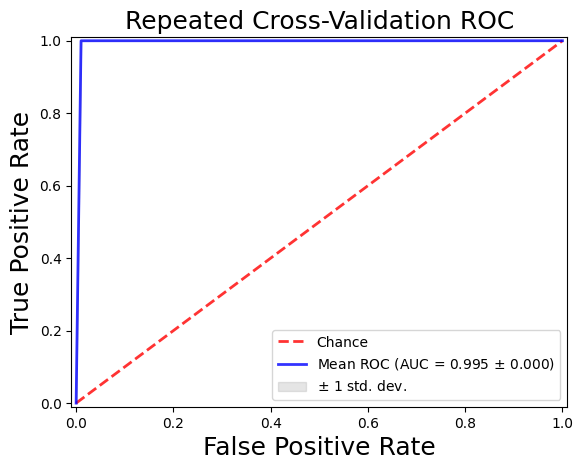

Accuracy: 0.99858 +/- (0.00006):
Sensitivity: 0.99854 +/- (0.00014):
Specificity: 0.99863 +/- (0.00008):
ROC AUC: 0.99998 +/- (0.00000)


In [14]:
plt.plot([0,1], [0,1], linestyle='--', lw=2,color='r', label='Chance',alpha=0.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Repeated Cross-Validation ROC',fontsize=18)
plt.legend(loc="lower right")#,bbox_to_anchor=(1.65, 0.01), prop={'size': 10})

plt.show()    
#print('Accuracy: %.3f :\nSensitivity: %.3f:\nSpecificity: %.3f :\nROC AUC: %.3f ' % (acc, sens, spec, auc))
print('Accuracy: %.5f +/- (%.5f):\nSensitivity: %.5f +/- (%.5f):\nSpecificity: %.5f +/- (%.5f):\nROC AUC: %.5f +/- (%.5f)' % (np.mean(accuracy),np.std(accuracy),np.mean(sensitivity),np.std(sensitivity),np.mean(specificity),np.std(specificity),np.mean(rocauc),np.std(rocauc)))
#print('Accuracy: %.3f +/- (%.3f):\nSensitivity: %.3f +/- (%.3f):\nSpecificity: %.3f +/- (%.3f):' % (np.mean(accuracy),np.std(accuracy),np.mean(sensitivity),np.std(sensitivity),np.mean(specificity),np.std(specificity)))
#fill dataframe score xgboost
#dataframe for scores
df_score_acc=pd.DataFrame()
df_score_sens=pd.DataFrame()
df_score_spec=pd.DataFrame()
df_score_roc=pd.DataFrame()

df_score_xg=pd.DataFrame()
metric_name=[]

df_score_acc['Score']=accuracy
df_score_acc['Metrics']=np.repeat('Accuracy',len(accuracy))
df_score_acc['Classifier']=np.repeat('XGBOOST', len(accuracy))

df_score_sens['Score']=sensitivity
df_score_sens['Metrics']=np.repeat('Sensitivity',len(sensitivity))
df_score_sens['Classifier']=np.repeat('XGBOOST', len(sensitivity))

df_score_spec['Score']=specificity
df_score_spec['Metrics']=np.repeat('Specificity',len(specificity))
df_score_spec['Classifier']=np.repeat('XGBOOST', len(specificity))

df_score_roc['Score']=rocauc
df_score_roc['Metrics']=np.repeat('Roc AUC',len(rocauc))
df_score_roc['Classifier']=np.repeat('XGBOOST', len(rocauc))

df_score_xg=pd.concat([df_score_acc,df_score_sens,df_score_spec,df_score_roc])
#df_score_xg.to_csv('/home/federica/Scrivania/EEG_analysis/data/Parkinson/df_score_connectome_xg.csv')



In [14]:
#Random Forest classifier
#%%time
param_grid_rf = {
    'n_estimators': [50],# 100, 150],  
    'max_depth': [3], #5, 7],
   # 'subsample': [0.5],# 0.7, 1],
    'min_samples_split': [2],# 5, 10],  
    'min_samples_leaf': [1],# 2, 4],
}

rf_model = RandomForestClassifier()  # Creazione del modello RandomForestClassifier
grid_search = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', refit=True)  # Utilizzo di RandomForestClassifier 
# Fit the GridSearchCV object to the training data
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.iloc[:, 1:-1], shuffled_df.iloc[:, -1], test_size=0.2, random_state=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [15]:
y_pred = best_model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy_rf = accuracy_score(y_test, predictions)
recall_rf = recall_score(y_test, y_pred)
precision_rf = precision_score(y_test, y_pred)

print("Accuracy Random Forest Classifier: %.2f%%" % (accuracy_rf * 100.0))
print("Recall Random Forest Classifier: %.2f%%" % (recall_rf * 100.0))
print("Precision Random Forest Classifier: %.2f%%" % (precision_rf * 100.0))


Accuracy Random Forest Classifier: 99.75%
Recall Random Forest Classifier: 100.00%
Precision Random Forest Classifier: 99.49%


In [13]:
%%time
#xgb classifier
param_grid_xgb = {
    'max_depth': [3],#, 5, 7],
    'learning_rate': [0.1],# 0.01, 0.001],
    'subsample': [0.5],# 0.7, 1],
    'reg_alpha':[0],# 0.5, 1, 5],
    'reg_lambda':[0],# 0.5, 1, 5]   
}

xgb_model = xgb.XGBClassifier(tree_method="hist")
grid_search = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='accuracy',refit=True)
# Fit the GridSearchCV object to the training data
X_train, X_test, y_train, y_test = train_test_split(shuffled_df.iloc[:, 1:-1], shuffled_df.iloc[:, -1], test_size=0.2, random_state=0)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

CPU times: user 2.37 s, sys: 45.6 ms, total: 2.42 s
Wall time: 2.53 s


In [15]:
y_pred = best_model.predict(X_test)
predictions_xgb = [round(value) for value in y_pred]
# evaluate predictions
accuracy_xgb = accuracy_score(y_test, predictions_xgb)
recall_xgb = recall_score(y_test, y_pred)
precision_xgb = precision_score(y_test, y_pred)

print("Accuracy XGB Classifier: %.2f%%" % (accuracy_xgb * 100.0))
print("Recall XGB Classifier: %.2f%%" % (recall_xgb * 100.0))
print("Precision XGB Classifier: %.2f%%" % (precision_xgb * 100.0))


Accuracy XGB Classifier: 99.85%
Recall XGB Classifier: 99.85%
Precision XGB Classifier: 99.85%


In [16]:
#y_pred_exp=best_model.predict(shuffled_df.iloc[:,1:-1])

In [18]:
explainer = shap.Explainer(best_model, X_train)
explainer = shap.TreeExplainer(best_model, check_additivity=False)

In [19]:
X_train = pd.DataFrame(shuffled_df.iloc[:, 1:-1])
X_test = pd.DataFrame(shuffled_df.iloc[:, 1:-1])

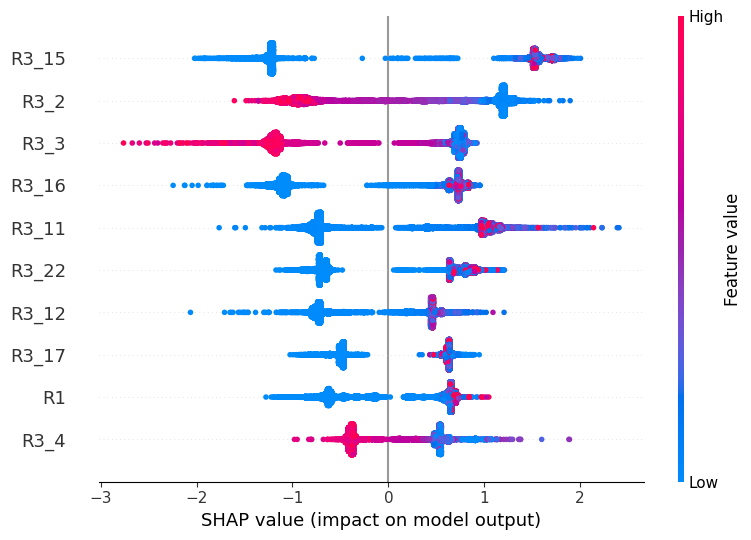

In [21]:
shap_values = explainer.shap_values(X_test)
fig = shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.savefig('scemo2.png')

In [20]:
y_pred

array([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,

,R1,R2,R4,R5,R6,R3_1,R3_2,R3_3,R3_4,R3_5,...,R3_16,R3_17,R3_18,R3_19,R3_20,R3_21,R3_22,R3_23,R3_24,R3_25
0,0.000019,0.230584,108.367859,540.0,-150.0,0.027728,0.162373,0.230584,0.212857,0.177886,...,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1,0.000159,0.261960,126.778166,630.0,-90.0,0.015684,0.103877,0.248023,0.261960,0.186947,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2,0.000115,0.278306,122.569456,510.0,-150.0,0.044462,0.191025,0.278306,0.207376,0.121290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
3,0.007263,0.145181,66.366593,750.0,-150.0,0.033836,0.078509,0.048052,0.053173,0.054413,...,0.017130,0.024895,0.028351,0.016155,0.013262,0.011684,0.006139,0.007263,0,0
4,0.006543,0.138331,108.613810,750.0,-270.0,0.003908,0.005790,0.008172,0.010076,0.008353,...,0.007553,0.010848,0.014708,0.022075,0.017287,0.029678,0.043192,0.006543,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.029907,0.190945,29.117513,750.0,-330.0,0.001917,0.003251,0.004247,0.005174,0.006719,...,0.020871,0.021396,0.026429,0.035932,0.031316,0.044882,0.026821,0.029907,0,0
1996,0.000089,0.221294,150.338964,570.0,-150.0,0.018413,0.120684,0.221294,0.199924,0.174405,...,0.000093,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1997,0.002773,0.174999,342.639990,750.0,-150.0,0.012838,0.041165,0.116257,0.174999,0.135706,...,0.023860,0.025831,0.014926,0.011368,0.012363,0.011536,0.003919,0.002773,0,0
1998,0.000083,0.271460,95.606059,450.0,-150.0,0.025572,0.166497,0.271460,0.255125,0.150521,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [ ]:
#for i in exp_df.Ev.unique():
#    hit_class_colors = exp_df[exp_df.Ev == i].y_pred.map({0: 'blue', 1: 'green'})
#    plt.scatter(exp_df[exp_df.Ev==i].x_hit,exp_df[exp_df.Ev==i].ly,c=hit_class_colors)
    
#    legend_labels = {'blue': 'Class 0', 'green': 'Class 1'}
#    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color], markerfacecolor=color, markersize=10) for color in ['blue', 'green']]
#    plt.legend(handles=legend_handles, loc='upper right')
#    plt.xlim(-40,40)
#    plt.show()